In [1]:
#  Import TensorFlow, OpenCV, Numpy, and CSV format processor
import tensorflow as tf
import numpy as np
import cv2
import csv
import random

# Import Keras modeuls
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
# utility to get an image from a file
def get_image(dirname, item_name):
        filename = item_name.split('/')[-1]
        img_path = dirname + '/IMG/' + filename
        image = cv2.imread(img_path)
        return image


In [3]:
# utility to get training data, return X_train, y_train
# directory of the data files
def get_train_data(dirname):   
    # data sturctures for images and measure angles 
    images = []
    angles = []
    with open(dirname + '/driving_log.csv', 'r') as csvFile:
        reader = csv.reader(csvFile)
        for row in reader:
            # center camera 
            image = get_image(dirname, row[0])
            images.append(image)
            angle = float(row[3])
            angles.append(angle)
            # flip image
            image_flipped = np.fliplr(image)
            images.append(image_flipped)
            angles.append(-angle)
            # left & right
            image_left = get_image(dirname, row[1])
            image_right = get_image(dirname, row[2])
            correction = 0.2 # this is a parameter to tune
            steering_left = angle + correction
            steering_right = angle - correction
            images.append(image_left)
            images.append(image_right)
            angles.append(steering_left)
            angles.append(steering_right)
            
    return np.array(images), np.array(angles)


In [4]:
# utility to draw randomly selected images in (rows*cols) with measurements as title
def draw_images(images, measures, rows, cols, figsz = (15, 6)):
    fig, axs = plt.subplots(rows,cols, figsize=figsz)
    fig.subplots_adjust(hspace = .5, wspace=.01)
    axs = axs.ravel()
    total = rows * cols
    for i in range(total):
        index = random.randint(0, len(images))
        image = images[index]
        axs[i].axis('off')
        axs[i].imshow(image)
        axs[i].set_title(measures[index])

X #:11968 shape:(160, 320, 3) y #:11968
X #:3156 shape:(160, 320, 3) y #:3156
X #:3192 shape:(160, 320, 3) y #:3192
X #:12336 shape:(160, 320, 3) y #:12336
X_train #:30652 y_train #:30652


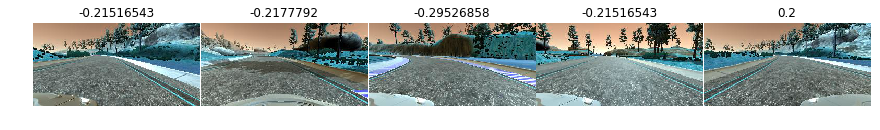

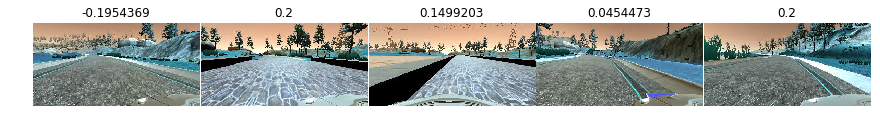

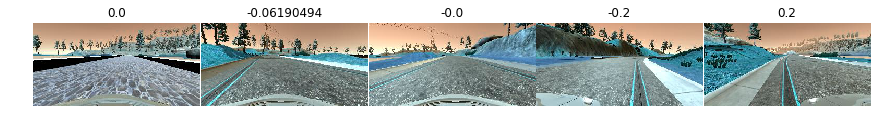

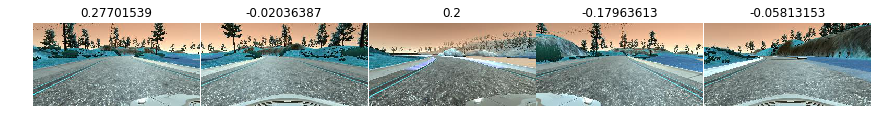

In [6]:
def print_train_data(train_x, train_y):
    print("X #:{} shape:{} y #:{}".format(len(train_x), train_x[0].shape, len(train_y)))
    
# get training images and measurement angles
X_train, y_train = get_train_data('extra/data/track1_central')
print_train_data(X_train, y_train)
draw_images(X_train, y_train, 1, 5)

X_train_r, y_train_r = get_train_data('extra/data/track1_recovery')
print_train_data(X_train_r, y_train_r)
draw_images(X_train_r, y_train_r, 1, 5)
X_train = np.concatenate((X_train, X_train_r), axis=0)
y_train = np.concatenate((y_train, y_train_r), axis=0)

X_train_rr, y_train_rr = get_train_data('extra/data/track1_recovery_reverse')
print_train_data(X_train_rr, y_train_rr)
draw_images(X_train_rr, y_train_rr, 1, 5)
X_train = np.concatenate((X_train, X_train_rr), axis=0)
y_train = np.concatenate((y_train, y_train_rr), axis=0)

X_train_rev, y_train_rev = get_train_data('extra/data/track1_reverse')
print_train_data(X_train_rev, y_train_rev)
X_train = np.concatenate((X_train, X_train_rev), axis=0)
y_train = np.concatenate((y_train, y_train_rev), axis=0)
print("X_train #:{} y_train #:{}".format(len(X_train), len(y_train)))
draw_images(X_train_rev, y_train_rev, 1, 5)

# shuffle train data
X_train, y_train = shuffle(X_train, y_train)

In [7]:
# uility to get a CNN model
def get_model():
    model = Sequential()
    # process images, normalization
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3) ))
    # process images, crop out top and bottom
    model.add(Cropping2D(cropping=((50,20),(0,0))))

    # convolution layers
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu', border_mode='valid'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu', border_mode='valid'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu', border_mode='valid'))
    model.add(Convolution2D(64,3,3, subsample=(1,1), activation='relu', border_mode='valid'))
    model.add(MaxPooling2D((2,2), border_mode='valid'))
    model.add(Dropout(0.4))

    #flatten
    model.add(Flatten())

    # direct connected layers
    model.add(Dense(100))
    model.add(Dropout(0.3))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    
    model.add(Dense(1))
    return model

In [8]:
# compile and train model
model = get_model()
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history_object = model.fit(X_train, y_train, nb_epoch=10, batch_size=512, validation_split=0.2, shuffle=True, verbose=1 )


Train on 24521 samples, validate on 6131 samples
Epoch 1/10
24521/24521 [==============================] - 359s - loss: 0.0228 - acc: 0.2035 - val_loss: 0.0151 - val_acc: 0.2058

In [9]:
filename = "./model_track1.h5"
model.save(filename)
print("{} is saved!".format(filename))

./model_track1.h5 is saved!


dict_keys(['val_acc', 'val_loss', 'loss', 'acc'])


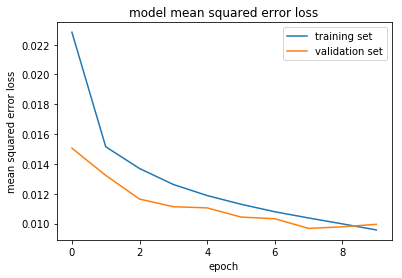

In [10]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()